### This notebook merge the 3 datasets (mouse brain Cusanovich, 10x, Fang) using 1 sample per dataset and the correct 10x file with preliminary filtering

### Trying different feature space reduction.
- Option 1: top 50000 features per datasets, then merge, then top 5000-10000 features on the intersection
    if there is not enough features in the intersection we need to increase the top 500000 to top 75k or more

- Option 2: calculate the variance of every feature (sum of all cells covered divided by the total nb of cells), take the top 20000 features the closest to 0.5 variance

In [46]:
import anndata as ad
import scanpy.api as sc
import episcanpy.api as epi
import numpy as np
import copy
import scipy
import pandas as pd
import seaborn as sns
import matplotlib as plt
import pandas as pd

In [2]:
sc.settings.set_figure_params(dpi=80, dpi_save=400)

In [3]:
DATADIR="/home/icb/chaichoompu/Group/workspace/Benchmarking_data_integration/data/brain_atac_3datasets"

In [4]:
# function to calculate the variance
def cal_var(adata):
    adata.var['n_cells'] = adata.X.sum(axis=0)
    adata.var['var_cells'] = adata.X.sum(axis=0)/len(adata.obs_names.tolist())
    
    # plotting
    #fig = plt.figure(figsize=(8,6))
    #sns.distplot(adata.var['n_cells']*100, bins=40)
    sns.distplot(adata.var['var_cells'], bins=40)
    #fig.legend(labels=['n_cells','var_cells'],
    #           loc='upper right')
    #plt.show()

# Load dataset #1: 10x data

In [4]:
# change the matrix loaded from nb2 to the original
adata_1st = ad.read(DATADIR+"/atac_v1_adult_brain_fresh_5k_sparse_bin_min500bins_min100cells.h5ad")

In [38]:
adata_1st

AnnData object with n_obs × n_vars = 4349 × 164259 
    obs: 'n_genes'
    var: 'chrom', 'chrom2', 'n_cells', 'var_cells'

In [39]:
print(np.max(adata_1st.X))
if np.max(adata_1st.X) > 1:
    epi.pp.binarize(adata_1st)

np.max(adata_1st.X)

1.0


1.0

In [40]:
adata_1st.var_names

Index(['chrY_90735001_90740000', 'chrY_90740001_90745000',
       'chrY_90760001_90765000', 'chrY_90795001_90800000',
       'chrY_90800001_90805000', 'chrY_90805001_90810000',
       'chrY_90810001_90815000', 'chrX_5765001_5770000',
       'chrX_6045001_6050000', 'chrX_6090001_6095000',
       ...
       'chr8_128705001_128710000', 'chr8_128715001_128720000',
       'chr8_128720001_128725000', 'chr8_128725001_128730000',
       'chr8_128730001_128735000', 'chr8_128735001_128740000',
       'chr8_128755001_128760000', 'chr8_128940001_128945000',
       'chr8_129230001_129235000', 'chr8_129260001_129265000'],
      dtype='object', length=164259)

In [41]:
bin_10x = ["_".join(n.split('-')) for n in adata_1st.var_names.tolist()]
bin_10x = ["_".join(n.split(':')) for n in bin_10x]
adata_1st.var_names = bin_10x

In [42]:
adata_1st.var_names

Index(['chrY_90735001_90740000', 'chrY_90740001_90745000',
       'chrY_90760001_90765000', 'chrY_90795001_90800000',
       'chrY_90800001_90805000', 'chrY_90805001_90810000',
       'chrY_90810001_90815000', 'chrX_5765001_5770000',
       'chrX_6045001_6050000', 'chrX_6090001_6095000',
       ...
       'chr8_128705001_128710000', 'chr8_128715001_128720000',
       'chr8_128720001_128725000', 'chr8_128725001_128730000',
       'chr8_128730001_128735000', 'chr8_128735001_128740000',
       'chr8_128755001_128760000', 'chr8_128940001_128945000',
       'chr8_129230001_129235000', 'chr8_129260001_129265000'],
      dtype='object', length=164259)

### select top variable features in the dataset

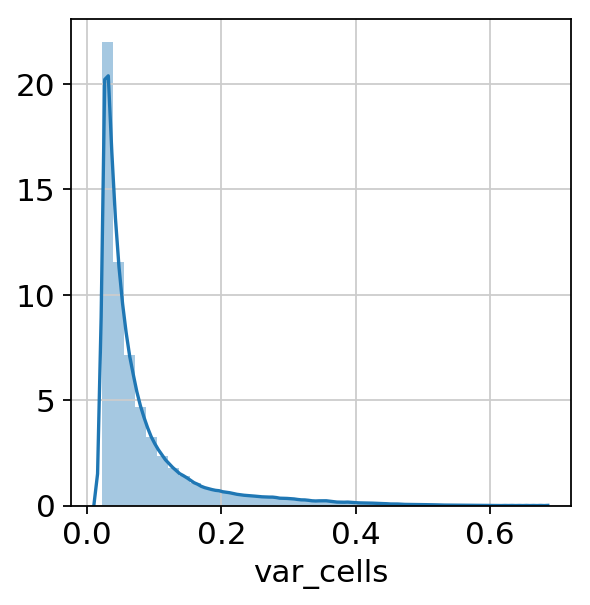

In [43]:
cal_var(adata_1st)

In [75]:
#adata_1st_2 = adata_1st[:,adata_1st.var['var_cells']>0.2]
#adata_1st_2
adata_1st_2 = adata_1st[:,adata_1st.var['var_cells']>0.055]
adata_1st_2

View of AnnData object with n_obs × n_vars = 4349 × 75397 
    obs: 'n_genes'
    var: 'chrom', 'chrom2', 'n_cells', 'var_cells'

# Load dataset #2: Fang et al 2019 data

In [ ]:
# To remind, there are the other files or cells as well
#CEMBA180308_3B_sparse_bin.h5ad
#CEMBA180306_2B_sparse_bin.h5ad
#CEMBA180305_2B_sparse_peak.h5ad
#CEMBA180227_1A_sparse_bin.h5ad
#CEMBA180226_1A_sparse_bin.h5ad

In [45]:
adata_2nd = ad.read(DATADIR+"/CEMBA180312_3B_sparse_bin.h5ad")

In [46]:
adata_2nd

AnnData object with n_obs × n_vars = 14930 × 545118 

In [47]:
print(np.max(adata_2nd.X))
if np.max(adata_2nd.X) > 1:
    epi.pp.binarize(adata_2nd)

np.max(adata_2nd.X)

1.0


1.0

In [48]:
adata_2nd.var_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '545108', '545109', '545110', '545111', '545112', '545113', '545114',
       '545115', '545116', '545117'],
      dtype='object', name='index', length=545118)

In [49]:
with open(DATADIR+"/CEMBA180312_3B_5kbin.txt") as f:
    bin_fang = f.readlines()
bin_fang = bin_fang[1:]
bin_fang = [n[:-1].split(' * ')[-1] for n in bin_fang]
adata_2nd.var_names = bin_fang

In [50]:
adata_2nd.var_names

Index(['chrY:1-5000', 'chrY:5001-10000', 'chrY:10001-15000',
       'chrY:15001-20000', 'chrY:20001-25000', 'chrY:25001-30000',
       'chrY:30001-35000', 'chrY:35001-40000', 'chrY:40001-45000',
       'chrY:45001-50000',
       ...
       'chr8:129355001-129360000', 'chr8:129360001-129365000',
       'chr8:129365001-129370000', 'chr8:129370001-129375000',
       'chr8:129375001-129380000', 'chr8:129380001-129385000',
       'chr8:129385001-129390000', 'chr8:129390001-129395000',
       'chr8:129395001-129400000', 'chr8:129400001-129405000'],
      dtype='object', length=545118)

In [51]:
new_name = adata_2nd.var_names.str.replace(':','_',regex=False)
new_name2 = new_name.str.replace('-','_',regex=False)
adata_2nd.var_names=new_name2
adata_2nd.var_names

Index(['chrY_1_5000', 'chrY_5001_10000', 'chrY_10001_15000',
       'chrY_15001_20000', 'chrY_20001_25000', 'chrY_25001_30000',
       'chrY_30001_35000', 'chrY_35001_40000', 'chrY_40001_45000',
       'chrY_45001_50000',
       ...
       'chr8_129355001_129360000', 'chr8_129360001_129365000',
       'chr8_129365001_129370000', 'chr8_129370001_129375000',
       'chr8_129375001_129380000', 'chr8_129380001_129385000',
       'chr8_129385001_129390000', 'chr8_129390001_129395000',
       'chr8_129395001_129400000', 'chr8_129400001_129405000'],
      dtype='object', length=545118)

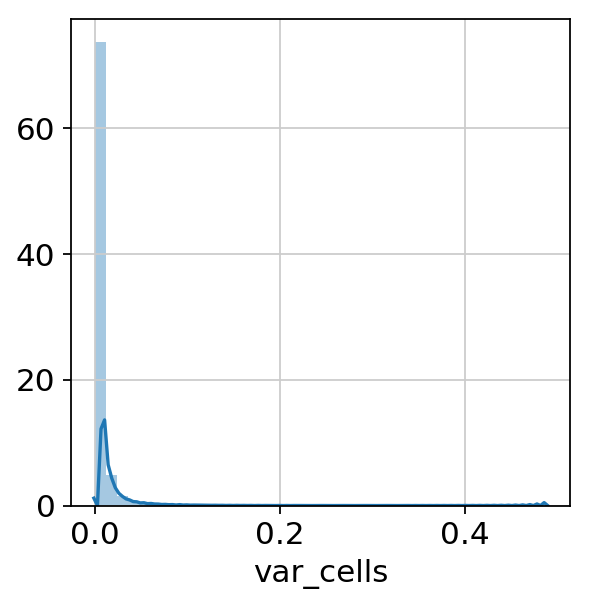

In [52]:
cal_var(adata_2nd)

In [54]:
adata_2nd_2 = adata_2nd[:,adata_2nd.var['var_cells']>0.2]
adata_2nd_2

View of AnnData object with n_obs × n_vars = 14930 × 138 
    var: 'n_cells', 'var_cells'

In [55]:
adata_2nd_2 = adata_2nd[:,adata_2nd.var['var_cells']>0.1]
adata_2nd_2

View of AnnData object with n_obs × n_vars = 14930 × 1891 
    var: 'n_cells', 'var_cells'

In [57]:
## too many cells have too less features. They are either too bad quality or not even cells (check out exp. protocol)

In [56]:
sc.pp.filter_cells(adata_2nd, min_genes=100)
adata_2nd

AnnData object with n_obs × n_vars = 14138 × 545118 
    obs: 'n_genes'
    var: 'n_cells', 'var_cells'

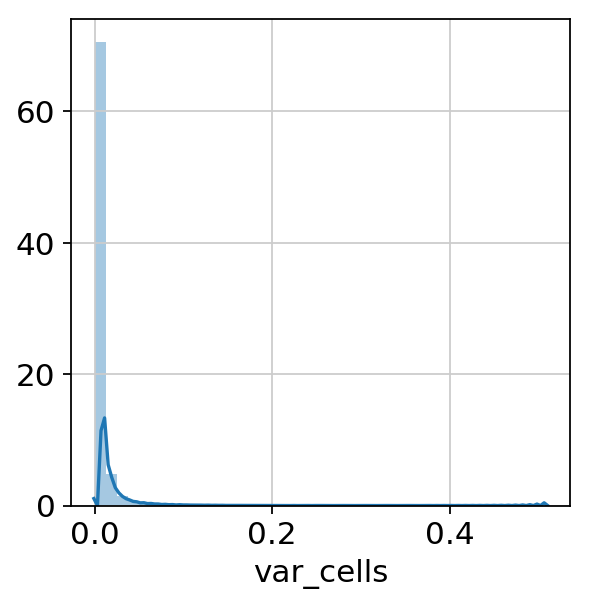

In [59]:
cal_var(adata_2nd)

In [60]:
adata_2nd_2 = adata_2nd[:,adata_2nd.var['var_cells']>0.1]
adata_2nd_2

View of AnnData object with n_obs × n_vars = 14138 × 2155 
    obs: 'n_genes'
    var: 'n_cells', 'var_cells'

In [61]:
adata_2nd_2 = adata_2nd[:,adata_2nd.var['var_cells']>0.01]
adata_2nd_2

View of AnnData object with n_obs × n_vars = 14138 × 73421 
    obs: 'n_genes'
    var: 'n_cells', 'var_cells'

# Load dataset #3: GSM3034638

In [62]:
adata_3rd = ad.read(DATADIR+"/GSM3034638_WholeBrainA_62816_5kbwindowmatrix_mm10.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [63]:
adata_3rd

AnnData object with n_obs × n_vars = 3386 × 349834 
    var: 'first_filtering', 'second_filtering', 'n_cells'

In [65]:
print(np.max(adata_3rd.X))
if np.max(adata_3rd.X) > 1:
    epi.pp.binarize(adata_3rd)

np.max(adata_3rd.X)

27.0


1.0

In [66]:
adata_3rd.var_names

Index(['chr1_3010000_3015000', 'chr1_3015000_3020000', 'chr1_3020000_3025000',
       'chr1_3025000_3030000', 'chr1_3030000_3035000', 'chr1_3035000_3040000',
       'chr1_3040000_3045000', 'chr1_3045000_3050000', 'chr1_3050000_3055000',
       'chr1_3055000_3060000',
       ...
       'chrY_4165000_4170000', 'chrY_4175000_4180000', 'chrY_4230000_4235000',
       'chrY_4225000_4230000', 'chrY_4220000_4225000', 'chrY_4210000_4215000',
       'chrY_4200000_4205000', 'chrY_4195000_4200000', 'chrY_4190000_4195000',
       'chrY_4185000_4190000'],
      dtype='object', name='index', length=349834)

In [67]:
adata_3rd_new_name = adata_3rd.var_names.str.replace('00_','01_',regex=False)
adata_3rd_new_name
adata_3rd.var_names=adata_3rd_new_name
adata_3rd.var_names

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Index(['chr1_3010001_3015000', 'chr1_3015001_3020000', 'chr1_3020001_3025000',
       'chr1_3025001_3030000', 'chr1_3030001_3035000', 'chr1_3035001_3040000',
       'chr1_3040001_3045000', 'chr1_3045001_3050000', 'chr1_3050001_3055000',
       'chr1_3055001_3060000',
       ...
       'chrY_4165001_4170000', 'chrY_4175001_4180000', 'chrY_4230001_4235000',
       'chrY_4225001_4230000', 'chrY_4220001_4225000', 'chrY_4210001_4215000',
       'chrY_4200001_4205000', 'chrY_4195001_4200000', 'chrY_4190001_4195000',
       'chrY_4185001_4190000'],
      dtype='object', name='index', length=349834)

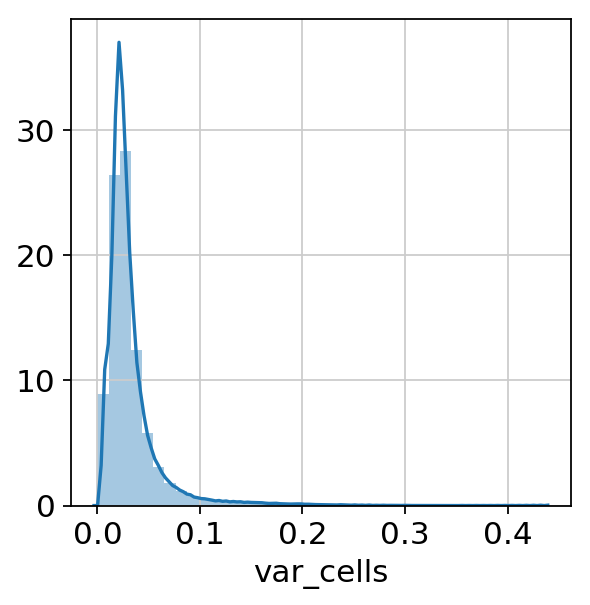

In [68]:
cal_var(adata_3rd)

In [69]:
adata_3rd_2 = adata_3rd[:,adata_3rd.var['var_cells']>0.1]
adata_3rd_2

View of AnnData object with n_obs × n_vars = 3386 × 11115 
    var: 'first_filtering', 'second_filtering', 'n_cells', 'var_cells'

In [71]:
adata_3rd_2 = adata_3rd[:,adata_3rd.var['var_cells']>0.04]
adata_3rd_2

View of AnnData object with n_obs × n_vars = 3386 × 71216 
    var: 'first_filtering', 'second_filtering', 'n_cells', 'var_cells'

# Filter only matched variables

In [76]:
keep = []
bin_10x = adata_1st_2.var_names.tolist()
bin_fang = adata_2nd_2.var_names.tolist()
for n2 in bin_fang:
    if n2 in bin_10x:
        keep.append('keep')
    else:
        keep.append('discard')
        
adata_2nd_2.var['overlap10x'] = keep
adata_2nd_2 = adata_2nd_2[:,adata_2nd_2.var['overlap10x']=='keep']
adata_2nd_2

Trying to set attribute `.var` of view, making a copy.


View of AnnData object with n_obs × n_vars = 14138 × 59104 
    obs: 'n_genes'
    var: 'n_cells', 'var_cells', 'overlap10x'

In [77]:
print(adata_1st_2.var_names.size)
print(adata_2nd_2.var_names.size)
print(adata_3rd_2.var_names.size)

75397
59104
71216


In [78]:
var_names_1_2 = adata_1st_2.var_names.intersection(adata_2nd_2.var_names)
print(var_names_1_2.size)

59104


In [79]:
var_names_1_2_3 = var_names_1_2.intersection(adata_3rd_2.var_names)
print(var_names_1_2_3.size)

35196


In [80]:
keep = np.repeat(0, adata_1st_2.var_names.size)
in_set = adata_1st_2.var_names.isin(var_names_1_2_3)
for i in range(in_set.size):
    if in_set[i] == True:
        keep[i] = 1

adata_1st_2.var['overlap_3datasets'] = keep
adata_1st_2

Trying to set attribute `.var` of view, making a copy.


AnnData object with n_obs × n_vars = 4349 × 75397 
    obs: 'n_genes'
    var: 'chrom', 'chrom2', 'n_cells', 'var_cells', 'overlap_3datasets'

In [81]:
adata_1st_overlap = copy.copy(adata_1st_2)
adata_1st_overlap = adata_1st_overlap[:,adata_1st_overlap.var['overlap_3datasets']==1]
adata_1st_overlap

View of AnnData object with n_obs × n_vars = 4349 × 35196 
    obs: 'n_genes'
    var: 'chrom', 'chrom2', 'n_cells', 'var_cells', 'overlap_3datasets'

In [82]:
keep = np.repeat(0, adata_2nd_2.var_names.size)
in_set = adata_2nd_2.var_names.isin(var_names_1_2_3)
for i in range(in_set.size):
    if in_set[i] == True:
        keep[i] = 1

adata_2nd_2.var['overlap_3datasets'] = keep
adata_2nd_2

Trying to set attribute `.var` of view, making a copy.


AnnData object with n_obs × n_vars = 14138 × 59104 
    obs: 'n_genes'
    var: 'n_cells', 'var_cells', 'overlap10x', 'overlap_3datasets'

In [83]:
adata_2nd_overlap = copy.copy(adata_2nd_2)
adata_2nd_overlap = adata_2nd_overlap[:,adata_2nd_overlap.var['overlap_3datasets']==1]
adata_2nd_overlap

View of AnnData object with n_obs × n_vars = 14138 × 35196 
    obs: 'n_genes'
    var: 'n_cells', 'var_cells', 'overlap10x', 'overlap_3datasets'

In [84]:
keep = np.repeat(0, adata_3rd_2.var_names.size)
in_set = adata_3rd_2.var_names.isin(var_names_1_2_3)
for i in range(in_set.size):
    if in_set[i] == True:
        keep[i] = 1

adata_3rd_2.var['overlap_3datasets'] = keep
adata_3rd_2

Trying to set attribute `.var` of view, making a copy.


AnnData object with n_obs × n_vars = 3386 × 71216 
    var: 'first_filtering', 'second_filtering', 'n_cells', 'var_cells', 'overlap_3datasets'

In [85]:
adata_3rd_overlap = copy.copy(adata_3rd_2)
adata_3rd_overlap = adata_3rd_overlap[:,adata_3rd_overlap.var['overlap_3datasets']==1]
adata_3rd_overlap

View of AnnData object with n_obs × n_vars = 3386 × 35196 
    var: 'first_filtering', 'second_filtering', 'n_cells', 'var_cells', 'overlap_3datasets'

In [86]:
# to verify that all variables are unique
print(adata_1st_overlap.var_names.unique)
print(adata_2nd_overlap.var_names.unique)
print(adata_3rd_overlap.var_names.unique)

<bound method Index.unique of Index(['chrX_7375001_7380000', 'chrX_7415001_7420000', 'chrX_7575001_7580000',
       'chrX_7605001_7610000', 'chrX_7635001_7640000', 'chrX_7645001_7650000',
       'chrX_7655001_7660000', 'chrX_7695001_7700000', 'chrX_7945001_7950000',
       'chrX_8095001_8100000',
       ...
       'chr8_127910001_127915000', 'chr8_128000001_128005000',
       'chr8_128030001_128035000', 'chr8_128200001_128205000',
       'chr8_128270001_128275000', 'chr8_128360001_128365000',
       'chr8_128490001_128495000', 'chr8_128650001_128655000',
       'chr8_128680001_128685000', 'chr8_128720001_128725000'],
      dtype='object', length=35196)>
<bound method Index.unique of Index(['chrX_7375001_7380000', 'chrX_7415001_7420000', 'chrX_7575001_7580000',
       'chrX_7605001_7610000', 'chrX_7635001_7640000', 'chrX_7645001_7650000',
       'chrX_7655001_7660000', 'chrX_7695001_7700000', 'chrX_7945001_7950000',
       'chrX_8095001_8100000',
       ...
       'chr8_127910001_127915

In [87]:
# uncomment this line to save the data
#adata_1st_overlap.write(DATADIR+"/overlapped_wt_3datasets_10x_top_var_feat.h5ad")
#adata_2nd_overlap.write(DATADIR+"/overlapped_wt_3datasets_CEMBA180312_3B_top_var_feat.h5ad")
#adata_3rd_overlap.write(DATADIR+"/overlapped_wt_3datasets_GSM3034638_top_var_feat.h5ad")

Trying to set attribute `.var` of view, making a copy.
... storing 'overlap10x' as categorical


# Concatenate all datasets

## The 1st and 2nd datasets

In [5]:
# uncomment this line to save the data
adata_1st_overlap = sc.read(DATADIR+"/overlapped_wt_3datasets_10x_top_var_feat.h5ad")
adata_2nd_overlap = sc.read(DATADIR+"/overlapped_wt_3datasets_CEMBA180312_3B_top_var_feat.h5ad")
adata_3rd_overlap = sc.read(DATADIR+"/overlapped_wt_3datasets_GSM3034638_top_var_feat.h5ad")

In [6]:
adata_merge_1_2 = adata_1st_overlap.concatenate(adata_2nd_overlap)

In [7]:
adata_merge_1_2

AnnData object with n_obs × n_vars = 18487 × 35196 
    obs: 'batch', 'n_genes'
    var: 'chrom-0', 'chrom2-0', 'n_cells-0', 'var_cells-0', 'overlap_3datasets', 'n_cells-1', 'var_cells-1', 'overlap10x-1'

## To Add the label of batches for the 1st and 2nd datasets

In [8]:
batchname=copy.copy(adata_merge_1_2.obs['batch'])
batchname

9-0        0
17-0       0
37-0       0
39-0       0
43-0       0
          ..
14925-1    1
14926-1    1
14927-1    1
14928-1    1
14929-1    1
Name: batch, Length: 18487, dtype: category
Categories (2, object): [0, 1]

In [9]:
batchname = batchname.map({ '1' : 'Fang et al. 2019', '0' : '10x Genomics' })
batchname

9-0            10x Genomics
17-0           10x Genomics
37-0           10x Genomics
39-0           10x Genomics
43-0           10x Genomics
                 ...       
14925-1    Fang et al. 2019
14926-1    Fang et al. 2019
14927-1    Fang et al. 2019
14928-1    Fang et al. 2019
14929-1    Fang et al. 2019
Name: batch, Length: 18487, dtype: category
Categories (2, object): [10x Genomics, Fang et al. 2019]

In [10]:
adata_merge_1_2.obs['batchname'] = batchname
adata_merge_1_2

AnnData object with n_obs × n_vars = 18487 × 35196 
    obs: 'batch', 'n_genes', 'batchname'
    var: 'chrom-0', 'chrom2-0', 'n_cells-0', 'var_cells-0', 'overlap_3datasets', 'n_cells-1', 'var_cells-1', 'overlap10x-1'

## concatenate the 1st-2nd dataset and the 3rd dataset

In [90]:
# uncomment this line to read the data
#adata = sc.read(DATADIR+"/merge_10x_CEMBA180312_3B_GSM3034638_bin_merged.h5ad")
#adata

In [12]:
adata_merge_all = adata_merge_1_2.concatenate(adata_3rd_overlap)

In [13]:
adata_merge_all

AnnData object with n_obs × n_vars = 21873 × 35196 
    obs: 'batch', 'batchname', 'n_genes'
    var: 'chrom-0-0', 'chrom2-0-0', 'n_cells-0-0', 'var_cells-0-0', 'overlap_3datasets', 'n_cells-1-0', 'var_cells-1-0', 'overlap10x-1-0', 'first_filtering-1', 'second_filtering-1', 'n_cells-1', 'var_cells-1'

## To Add the label of the batches to 3 datasets

In [14]:
adata_merge_all.obs['batchname']

9-0-0                                     10x Genomics
17-0-0                                    10x Genomics
37-0-0                                    10x Genomics
39-0-0                                    10x Genomics
43-0-0                                    10x Genomics
                                              ...     
TCTCGCGCTTGCTTAGATGAGACCTACCTATAGCCT-1             NaN
TCTCGCGCTTGCTTAGATGTCTGCAATCCCTATCCT-1             NaN
TCTCGCGCTTGCTTAGATGTCTGCAATCTATAGCCT-1             NaN
TCTCGCGCTTGCTTAGATGTTGGATCTTAGGCGAAG-1             NaN
TCTCGCGCTTGCTTAGATGTTGGATCTTGTACTGAC-1             NaN
Name: batchname, Length: 21873, dtype: object

In [15]:
new_batch = adata_merge_all.obs['batchname'].replace(np.nan, 'GSM3034638', regex=False)
new_batch

9-0-0                                     10x Genomics
17-0-0                                    10x Genomics
37-0-0                                    10x Genomics
39-0-0                                    10x Genomics
43-0-0                                    10x Genomics
                                              ...     
TCTCGCGCTTGCTTAGATGAGACCTACCTATAGCCT-1      GSM3034638
TCTCGCGCTTGCTTAGATGTCTGCAATCCCTATCCT-1      GSM3034638
TCTCGCGCTTGCTTAGATGTCTGCAATCTATAGCCT-1      GSM3034638
TCTCGCGCTTGCTTAGATGTTGGATCTTAGGCGAAG-1      GSM3034638
TCTCGCGCTTGCTTAGATGTTGGATCTTGTACTGAC-1      GSM3034638
Name: batchname, Length: 21873, dtype: object

In [16]:
adata_merge_all.obs['batchname'] = new_batch
adata_merge_all.obs['batchname']

9-0-0                                     10x Genomics
17-0-0                                    10x Genomics
37-0-0                                    10x Genomics
39-0-0                                    10x Genomics
43-0-0                                    10x Genomics
                                              ...     
TCTCGCGCTTGCTTAGATGAGACCTACCTATAGCCT-1      GSM3034638
TCTCGCGCTTGCTTAGATGTCTGCAATCCCTATCCT-1      GSM3034638
TCTCGCGCTTGCTTAGATGTCTGCAATCTATAGCCT-1      GSM3034638
TCTCGCGCTTGCTTAGATGTTGGATCTTAGGCGAAG-1      GSM3034638
TCTCGCGCTTGCTTAGATGTTGGATCTTGTACTGAC-1      GSM3034638
Name: batchname, Length: 21873, dtype: object

In [17]:
# uncomment this line to save the data
#adata_merge_all.write(DATADIR+"/merge_10x_CEMBA180312_3B_GSM3034638_bin_merged_top_var_feat.h5ad")

... storing 'batchname' as categorical
... storing 'chrom-0-0' as categorical
... storing 'chrom2-0-0' as categorical
... storing 'overlap10x-1-0' as categorical
... storing 'first_filtering-1' as categorical


# QC for merged datasets

In [80]:
# read the intermediate files 
adata_merge_all = sc.read(DATADIR+"/merge_10x_CEMBA180312_3B_GSM3034638_bin_merged_top_var_feat.h5ad")
sc.pp.filter_cells(adata_merge_all, min_genes=1)
adata_merge_all.obs['n_counts'] = adata_merge_all.X.sum(axis=1)
adata_merge_all.obs['n_windows'] = adata_merge_all.obs['n_genes']
del adata_merge_all.obs['n_genes']
adata_merge_all

AnnData object with n_obs × n_vars = 21873 × 35196 
    obs: 'batch', 'batchname', 'n_counts', 'n_windows'
    var: 'chrom-0-0', 'chrom2-0-0', 'n_cells-0-0', 'var_cells-0-0', 'overlap_3datasets', 'n_cells-1-0', 'var_cells-1-0', 'overlap10x-1-0', 'first_filtering-1', 'second_filtering-1', 'n_cells-1', 'var_cells-1'

In [81]:
contingency_table_prefilt = pd.crosstab(adata_merge_all.obs['batchname'],
                                adata_merge_all.obs['batchname'],
                                margins = True)
contingency_table_prefilt

batchname         10x Genomics  Fang et al. 2019  GSM3034638    All
batchname                                                          
10x Genomics              4349                 0           0   4349
Fang et al. 2019             0             14138           0  14138
GSM3034638                   0                 0        3386   3386
All                       4349             14138        3386  21873

### epiScanpy QC

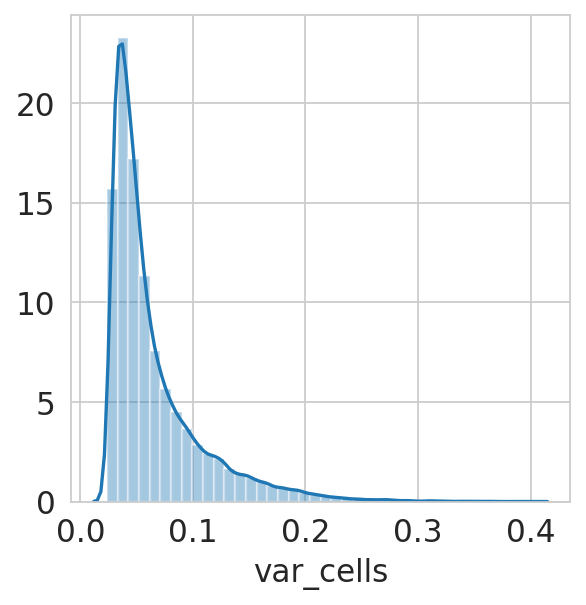

In [82]:
cal_var(adata_merge_all)

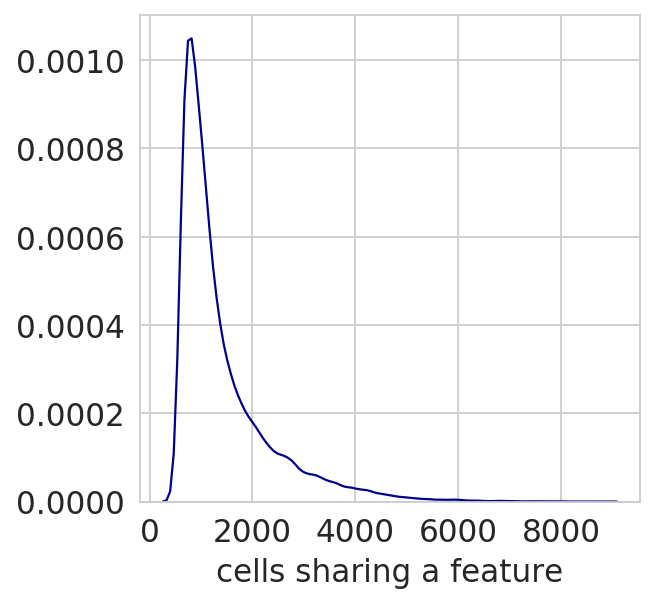

In [83]:
epi.pp.commonness_features(adata_merge_all)

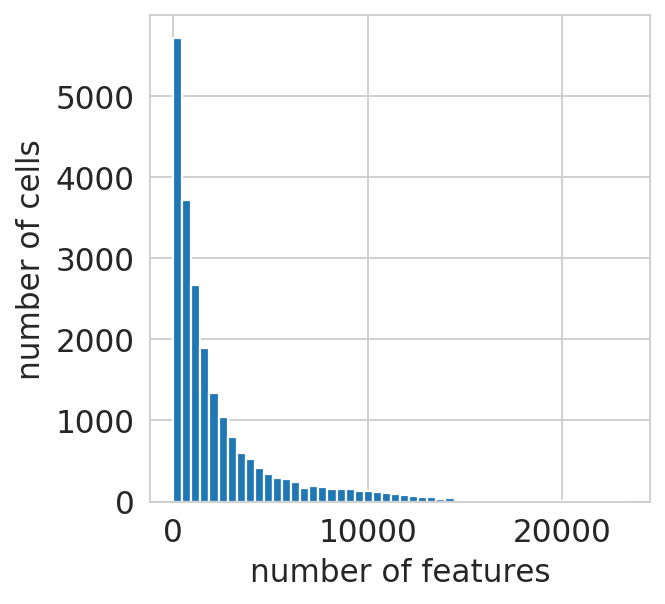

In [84]:
epi.pp.coverage_cells(adata_merge_all)

In [85]:
# Don't run it
#epi.pp.binarize(adata)
#np.max(adata.X)

In [86]:
#sc.pp.filter_cells(adata_merge_all, min_genes=10)

In [87]:
#print(adata_merge_all.var_names.size)
#print(adata_merge_all.obs_names.size)
#filter_min_cells = adata_merge_all.obs_names.size * 0.01
#filter_min_vars = adata_merge_all.var_names.size * 0.01
#filter_max_cells = adata_merge_all.obs_names.size * 0.99
#filter_max_vars = adata_merge_all.var_names.size * 0.99
#print(filter_min_vars)
#print(filter_max_vars)
#print(filter_min_cells)
#print(filter_max_cells)

In [88]:
#sc.pp.filter_genes(adata_merge_all, min_cells=filter_min_cells)
#sc.pp.filter_genes(adata_merge_all, max_cells=filter_max_cells)
#adata_merge_all

### We might have to take the top features of the shared feature space

In [89]:
sc.tl.pca(adata_merge_all)
sc.pp.neighbors(adata_merge_all)
sc.tl.tsne(adata_merge_all)
sc.tl.umap(adata_merge_all)

The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../home/icb/chaichoompu/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^



In [90]:
adata_merge_all

AnnData object with n_obs × n_vars = 21873 × 35196 
    obs: 'batch', 'batchname', 'n_counts', 'n_windows', 'sum_peaks'
    var: 'chrom-0-0', 'chrom2-0-0', 'n_cells-0-0', 'var_cells-0-0', 'overlap_3datasets', 'n_cells-1-0', 'var_cells-1-0', 'overlap10x-1-0', 'first_filtering-1', 'second_filtering-1', 'n_cells-1', 'var_cells-1', 'n_cells', 'var_cells', 'commonness'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

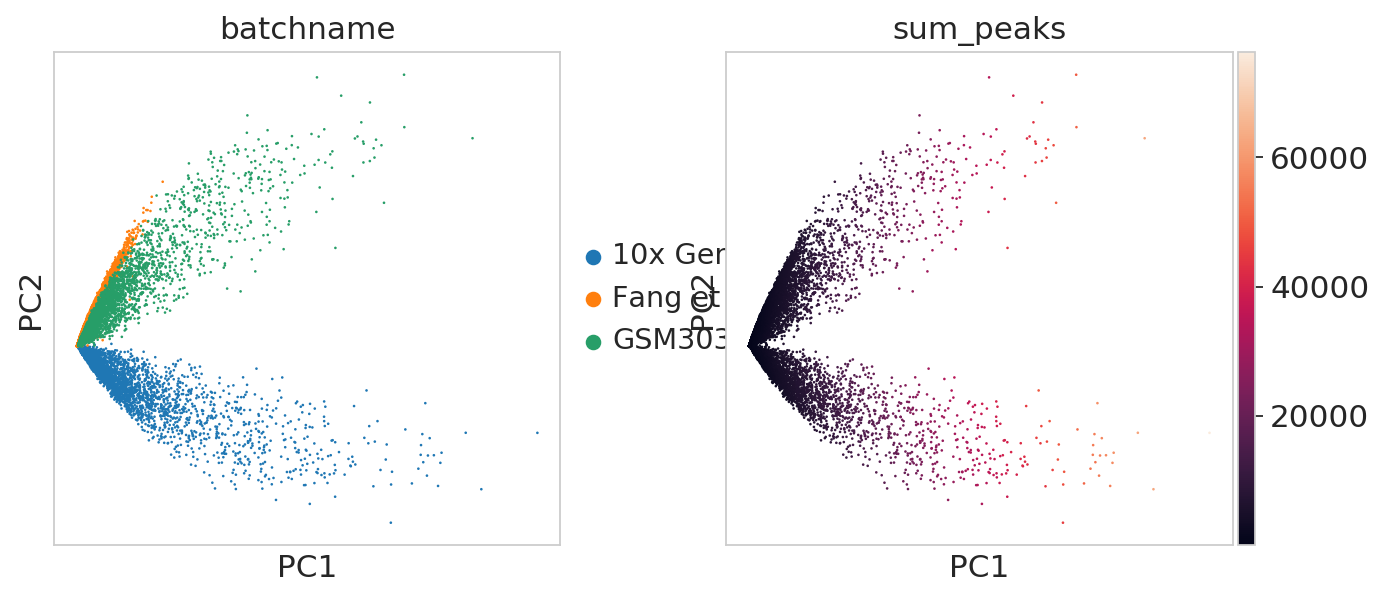

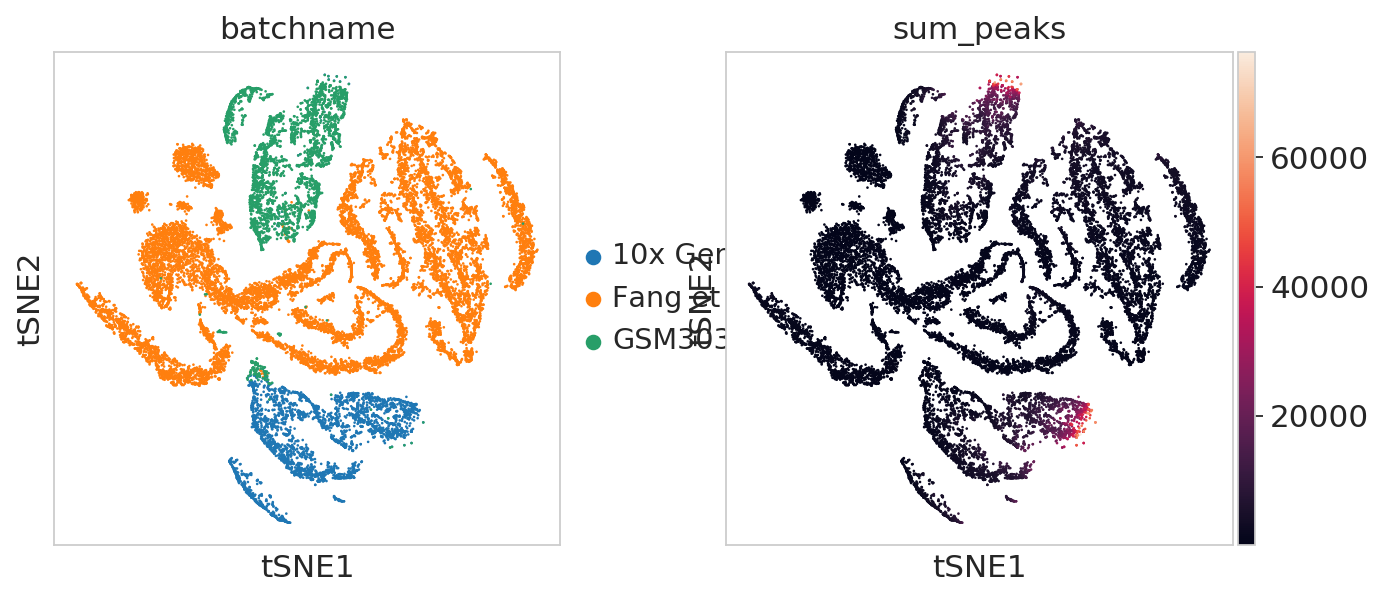

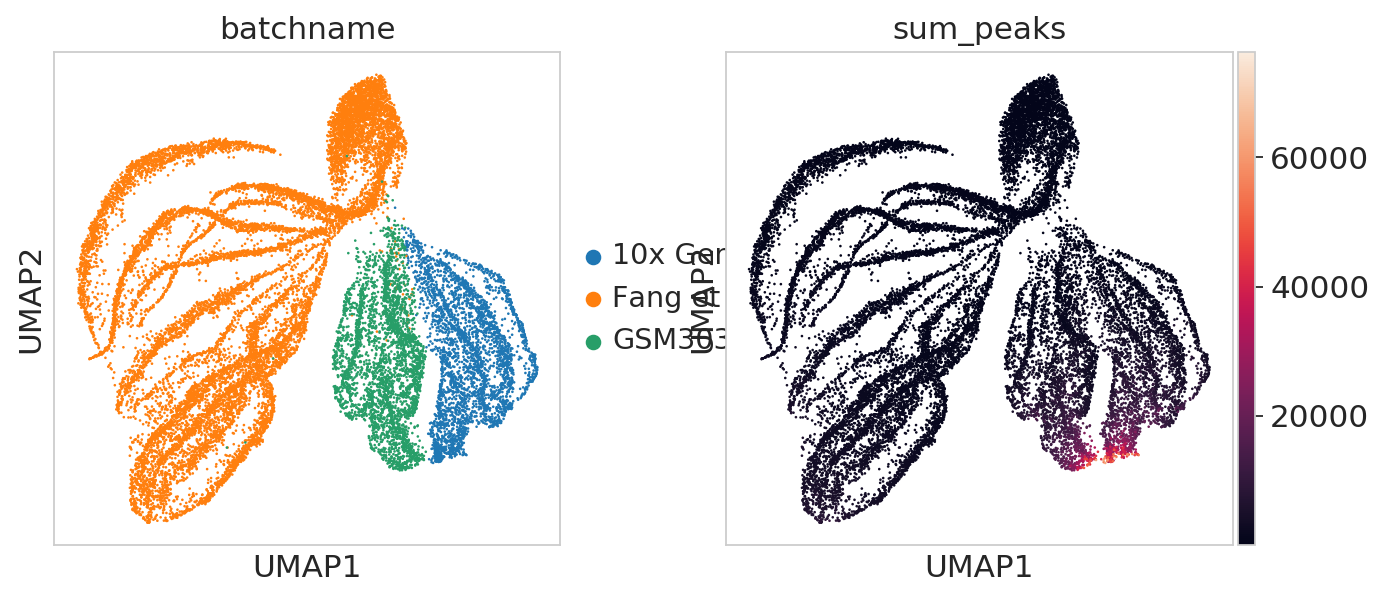

In [12]:
# previous plot generated by Kris (so no top feat selection, it is using the total intersection)
#sc.pl.pca(adata_merge_all, color=['batchname','sum_peaks'])
#sc.pl.tsne(adata_merge_all, color=['batchname','sum_peaks'])
#sc.pl.umap(adata_merge_all, color=['batchname','sum_peaks'])

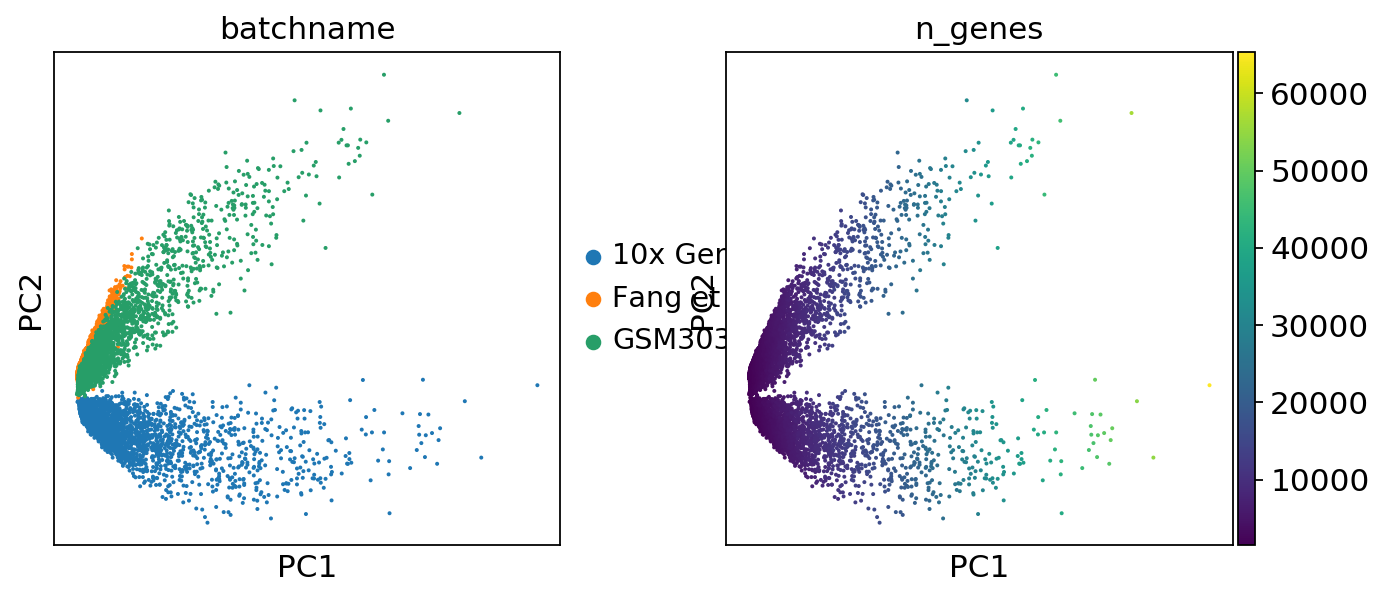

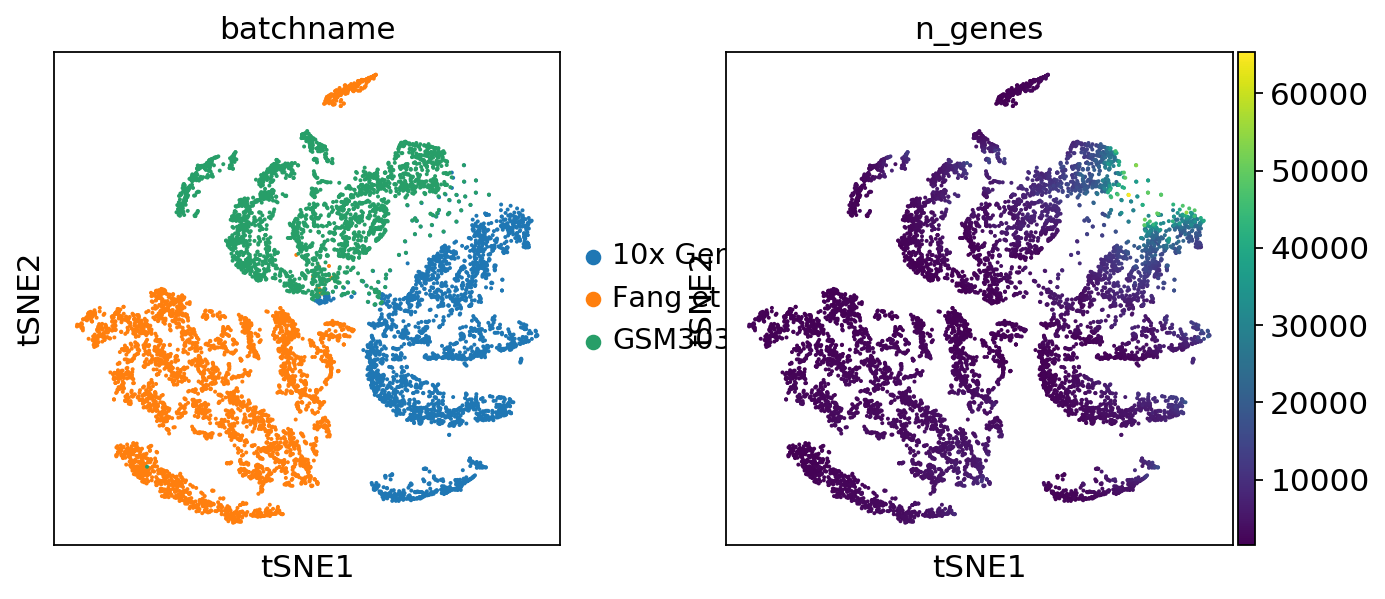

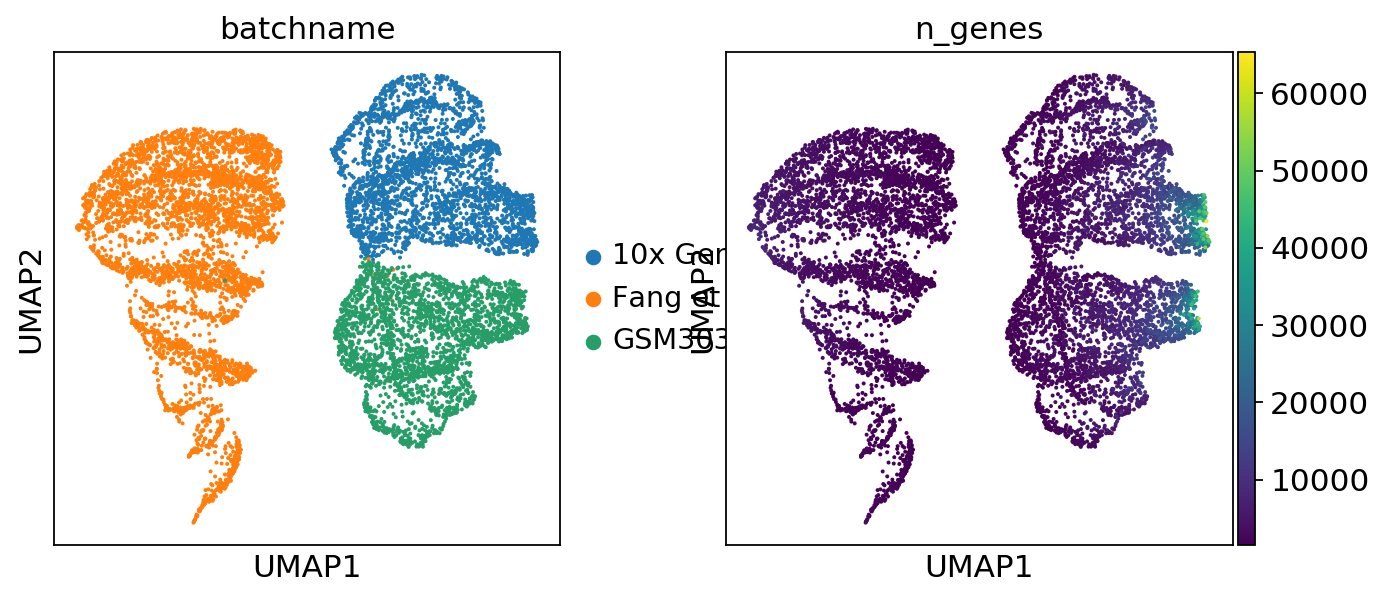

In [48]:
## This is plots from Kris
#fplot="_brain_atac_3datasets_filterRowCol.pdf"
#sc.pl.pca(adata_merge_all, color=['batchname','n_genes'], save=fplot)
#sc.pl.tsne(adata_merge_all, color=['batchname','n_genes'], save=fplot)
#sc.pl.umap(adata_merge_all, color=['batchname','n_genes'], save=fplot)

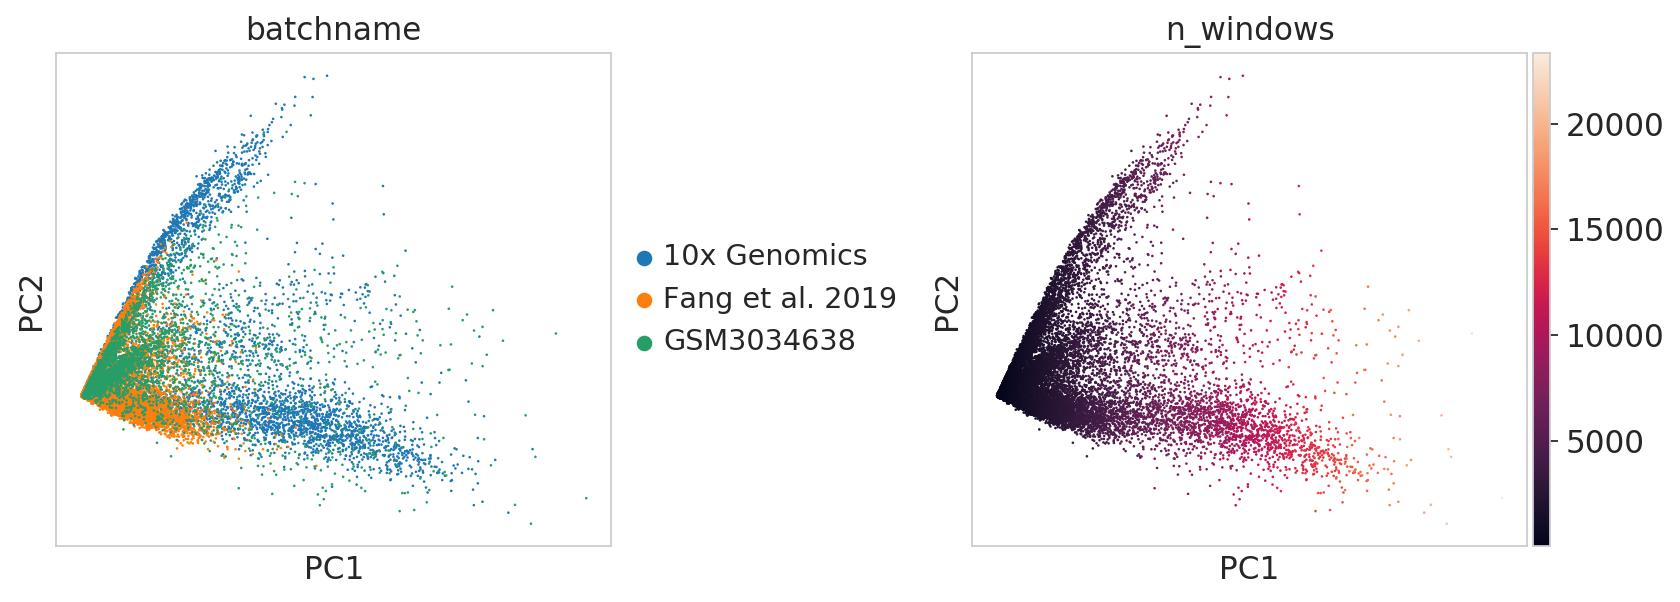

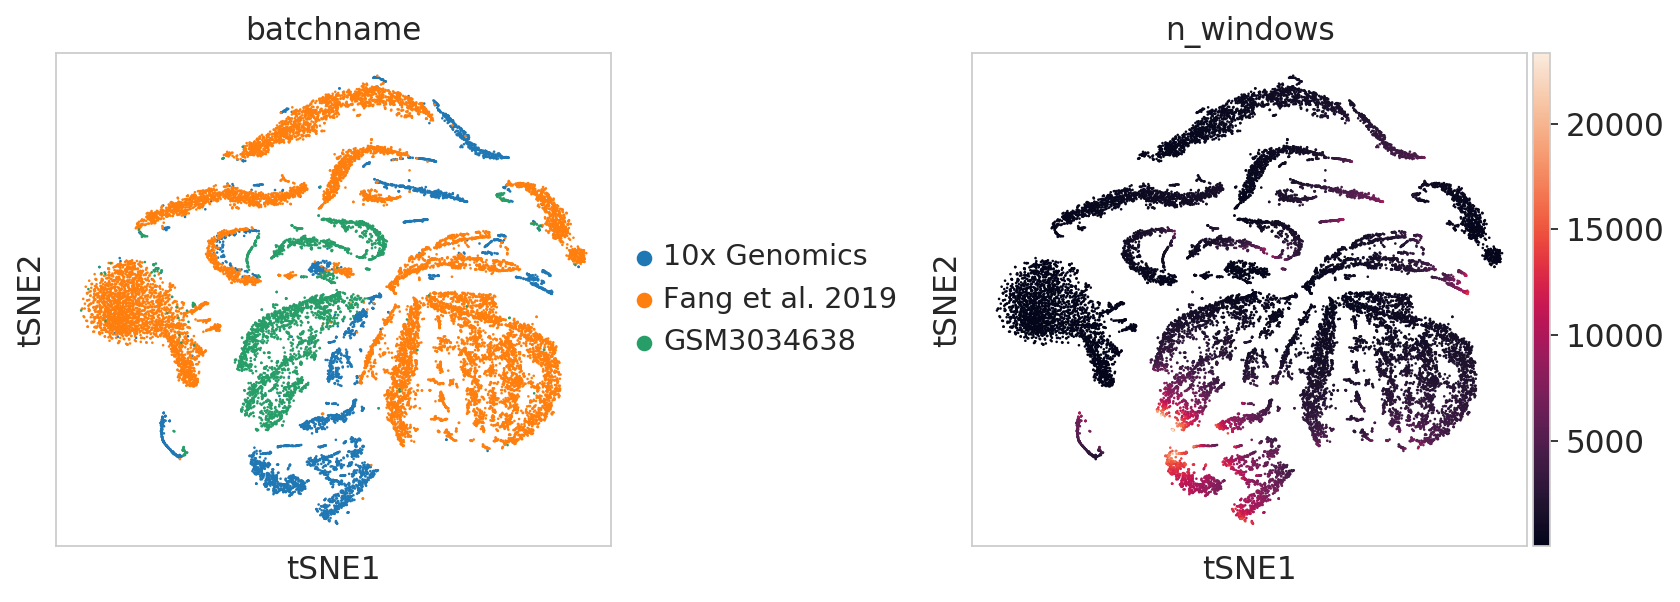

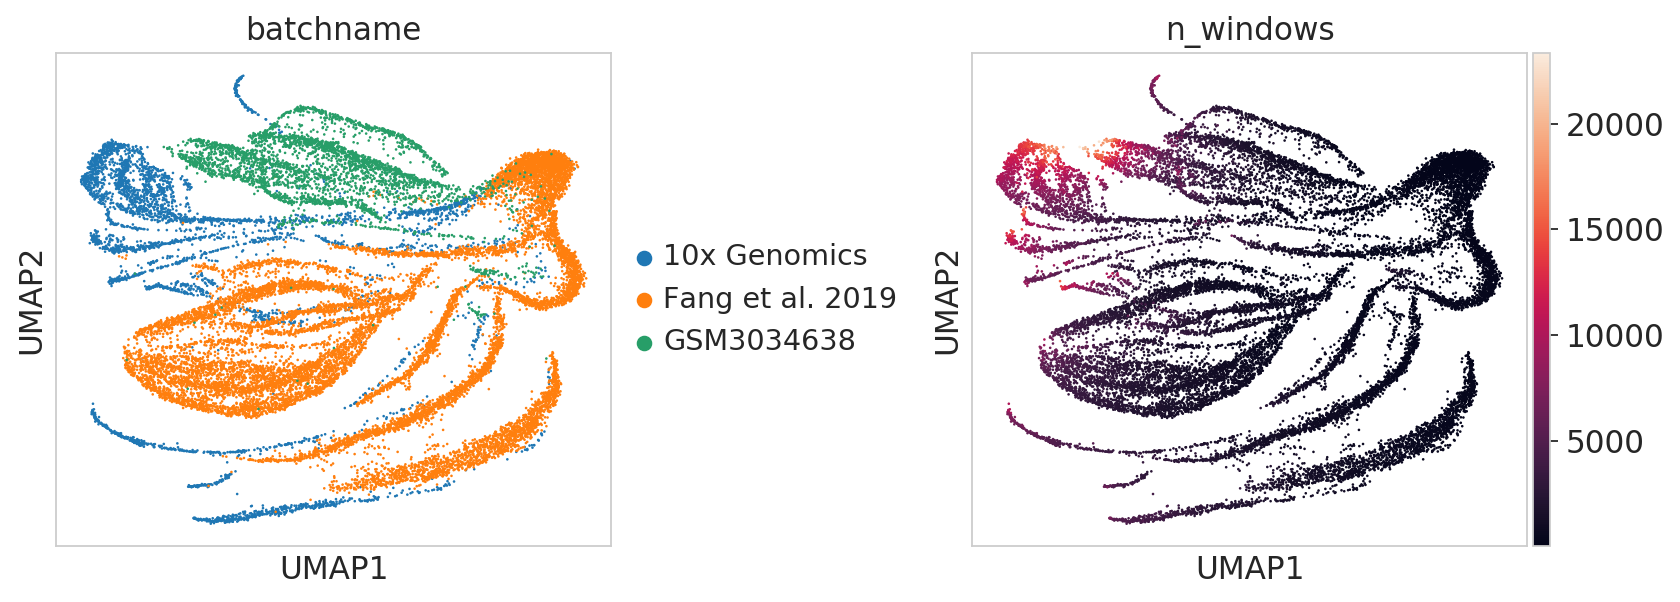

In [91]:
fplot="_brain_atac_3datasets_prefilter_top_var_feat.pdf"
sc.pl.pca(adata_merge_all, wspace=0.5, color=['batchname','n_windows'], save=fplot)
sc.pl.tsne(adata_merge_all, wspace=0.5, color=['batchname','n_windows'], save=fplot)
sc.pl.umap(adata_merge_all, wspace=0.5, color=['batchname','n_windows'], save=fplot)

## Filtering low quality cells on the merged datasets

In [93]:
contingency_table_prefilt

batchname         10x Genomics  Fang et al. 2019  GSM3034638    All
batchname                                                          
10x Genomics              4349                 0           0   4349
Fang et al. 2019             0             14138           0  14138
GSM3034638                   0                 0        3386   3386
All                       4349             14138        3386  21873

In [94]:
sc.pp.filter_cells(adata_merge_all, min_genes=100)

In [95]:
adata_merge_all

AnnData object with n_obs × n_vars = 19811 × 35196 
    obs: 'batch', 'batchname', 'n_counts', 'n_windows', 'sum_peaks', 'n_genes'
    var: 'chrom-0-0', 'chrom2-0-0', 'n_cells-0-0', 'var_cells-0-0', 'overlap_3datasets', 'n_cells-1-0', 'var_cells-1-0', 'overlap10x-1-0', 'first_filtering-1', 'second_filtering-1', 'n_cells-1', 'var_cells-1', 'n_cells', 'var_cells', 'commonness'
    uns: 'pca', 'neighbors', 'batchname_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [96]:
contingency_table_postfilt = pd.crosstab(adata_merge_all.obs['batchname'],
                                adata_merge_all.obs['batchname'],
                                margins = True)
contingency_table_postfilt

batchname         10x Genomics  Fang et al. 2019  GSM3034638    All
batchname                                                          
10x Genomics              4345                 0           0   4345
Fang et al. 2019             0             12086           0  12086
GSM3034638                   0                 0        3380   3380
All                       4345             12086        3380  19811

In [97]:
sc.tl.pca(adata_merge_all)
sc.pp.neighbors(adata_merge_all)
sc.tl.tsne(adata_merge_all)
sc.tl.umap(adata_merge_all)

The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../home/icb/chaichoompu/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^



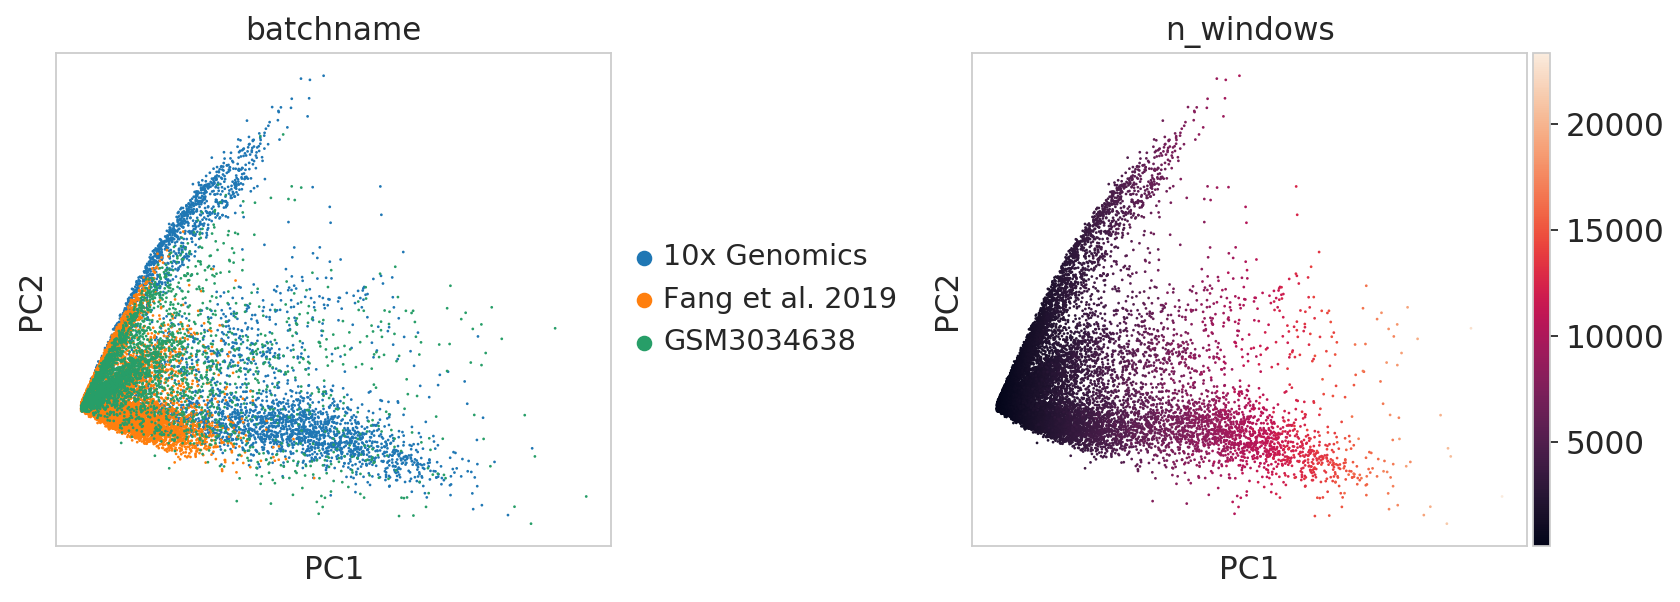

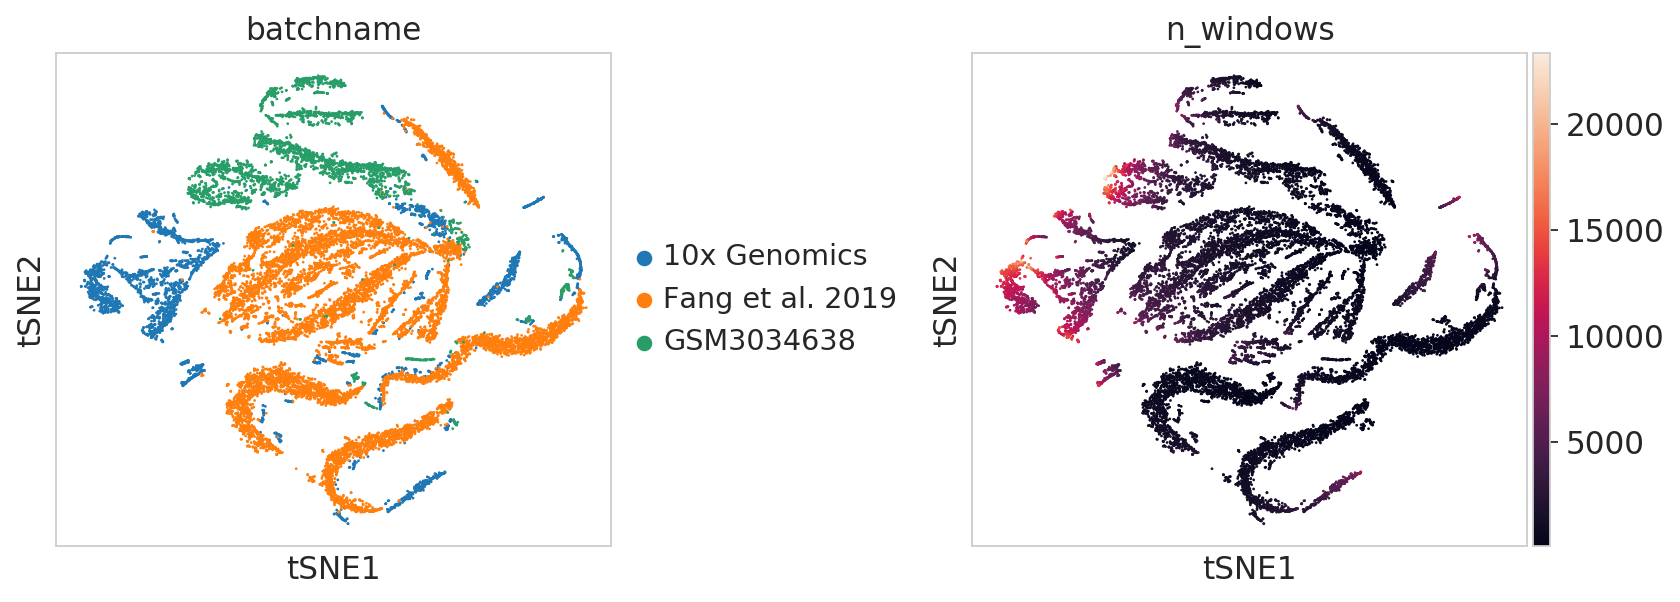

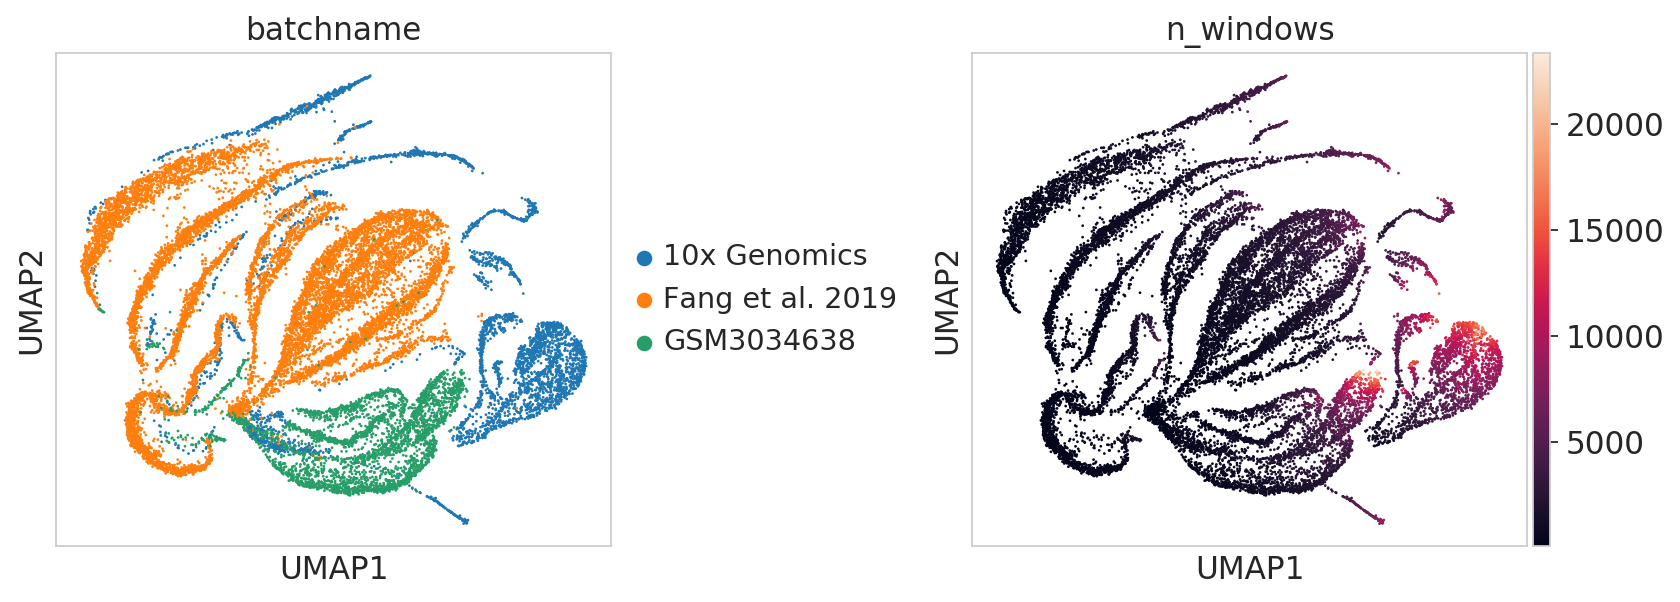

In [98]:
fplot="_brain_atac_3datasets_min100windows_top_var_feat.pdf"
sc.pl.pca(adata_merge_all, wspace=0.5, color=['batchname','n_windows'], save=fplot)
sc.pl.tsne(adata_merge_all, wspace=0.5, color=['batchname','n_windows'], save=fplot)
sc.pl.umap(adata_merge_all, wspace=0.5, color=['batchname','n_windows'], save=fplot)

In [99]:
# uncomment this line to save the data
#adata_merge_all.write(DATADIR+"/merge_10x_CEMBA180312_3B_GSM3034638_bin_merged_top_var_feat_min100cells.h5ad")

# Regression

In [ ]:
adata_merge_all=ad.read(DATADIR+"/merge_10x_CEMBA180312_3B_GSM3034638_bin_merged_top_var_feat_min100cells.h5ad")

In [101]:
sc.pp.regress_out(adata_merge_all, 'n_windows')

In [102]:
sc.pp.pca(adata_merge_all)
sc.pp.neighbors(adata_merge_all)
sc.tl.tsne(adata_merge_all)
sc.tl.umap(adata_merge_all)

The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../home/icb/chaichoompu/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^



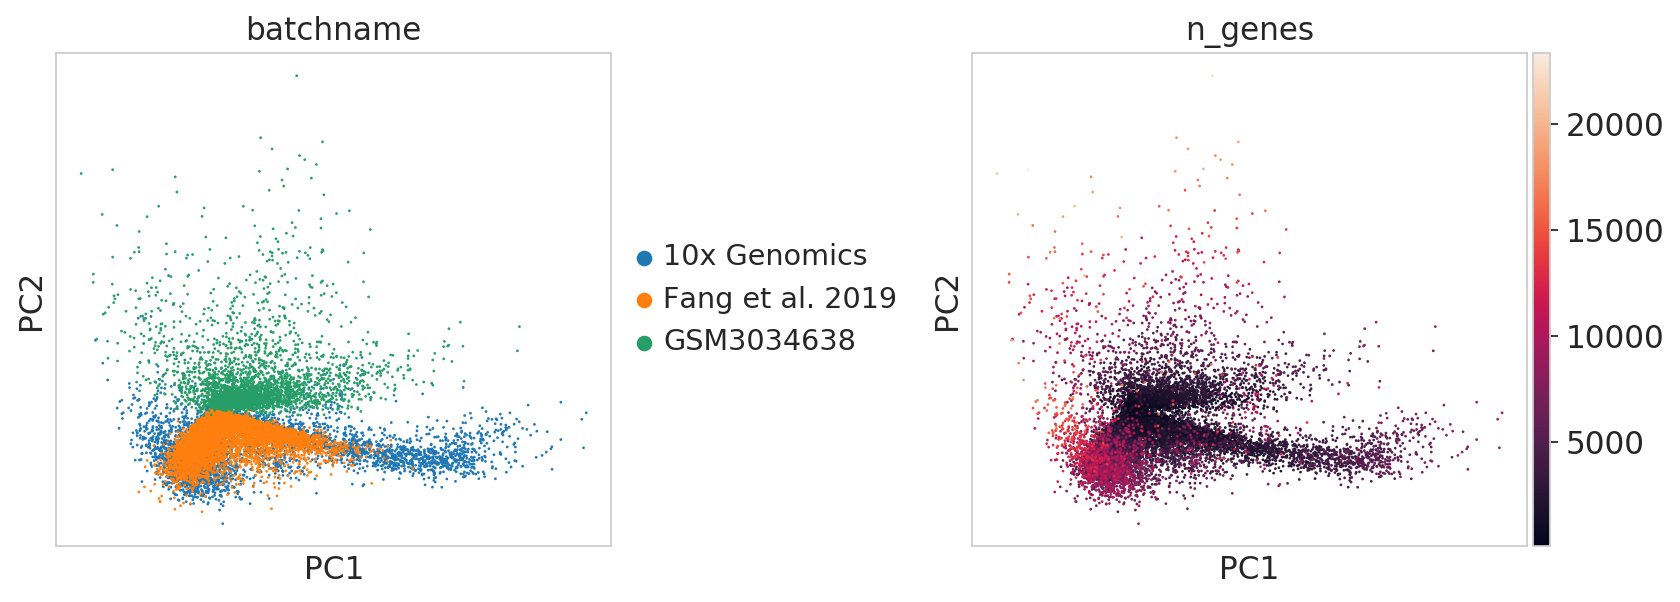

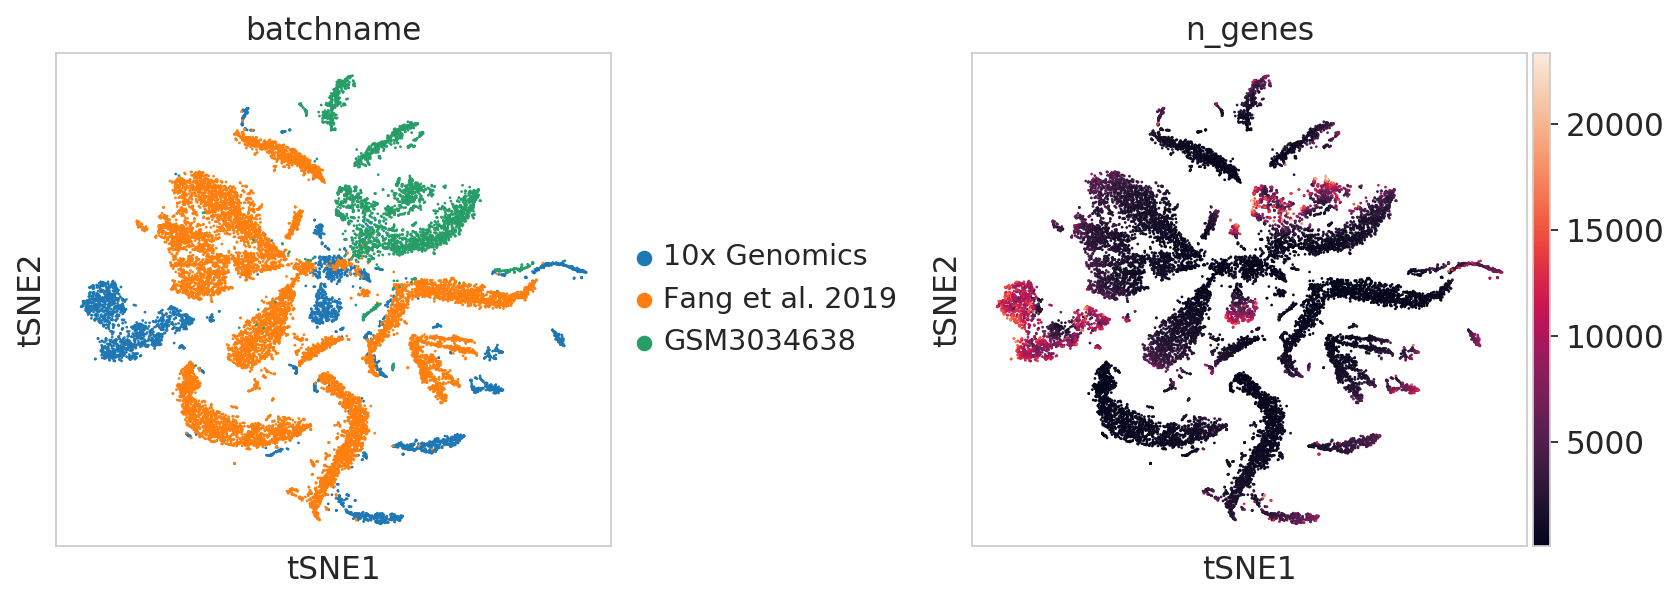

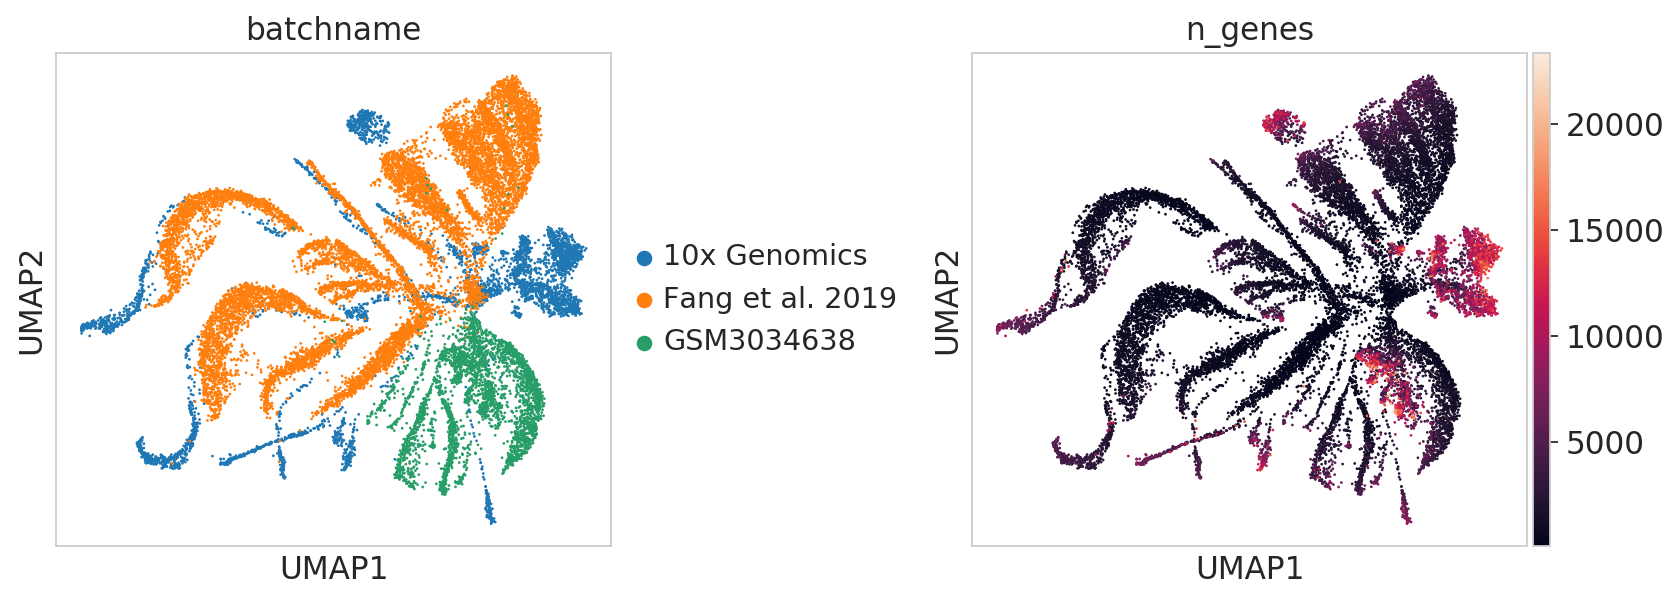

In [103]:
fplot="_brain_atac_3datasets_min100windows_top_var_feat_regression.pdf"
sc.pl.pca(adata_merge_all, wspace=0.5, color=['batchname', 'n_genes'],save=fplot)
sc.pl.tsne(adata_merge_all, wspace=0.5, color=['batchname', 'n_genes'],save=fplot)
sc.pl.umap(adata_merge_all, wspace=0.5, color=['batchname', 'n_genes'],save=fplot)

In [104]:
# uncomment this line to save the file
#adata_merge_all.write(DATADIR+"/merge_10x_CEMBA180312_3B_GSM3034638_bin_merged_top_var_feat_min100cells_regression.h5ad")

In [4]:
# read the intermediate files 
adata_merge_all = sc.read(DATADIR+"/merge_10x_CEMBA180312_3B_GSM3034638_bin_merged_filterRowCol_regression.h5ad")

In [105]:
# uncomment this line to save the file
#adata_merge_all.X = scipy.sparse.csr_matrix(adata_merge_all.X)
#adata_merge_all.write(DATADIR+"/merge_10x_CEMBA180312_3B_GSM3034638_bin_merged_top_var_feat_min100cells_regression_Seurat.h5ad")